# Importy

In [0]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance

from sklearn import manifold
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

# Pliki do pobrania

https://drive.google.com/drive/folders/1f4fqy3yywOpTIF2LlrEiA5PfKO_0Acbt?usp=sharing

# Generowanie danych

In [0]:
size = 200


def generate_sphere(center, dim, r):
  sphere = []

  for i in range(size):
      sphere += [[center + r * random.choice([-1, 1]) for j in range(0, dim)]]
      
  return np.array(sphere)

def generate_globe(center, dim, r):
  globe = [dim*[center]]

  for i in range(size):
      globe += [[center + random.uniform(-r, r) for j in range(0, dim)]]
           
  return np.array(globe)


sphere = generate_sphere(2, 10, 2)
globe = generate_globe(2, 10, 1)

X = np.concatenate((sphere, globe), axis=0)
y = len(sphere) * [1] + len(globe) * [0]

In [0]:
def printDataSet2D(points,which_set):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1, 1, 1) 
    colors = ['r', 'b']
    for a,b in zip(points,which_set):
            ax.scatter(a[0]
                       , a[1]
                       , c = colors[b]
                       , s = 50)
    plt.show()


# Porównanie metody PCA z MDS

## PCA

In [0]:
pca = PCA(n_components=2)
XPCA = pca.fit_transform(X)

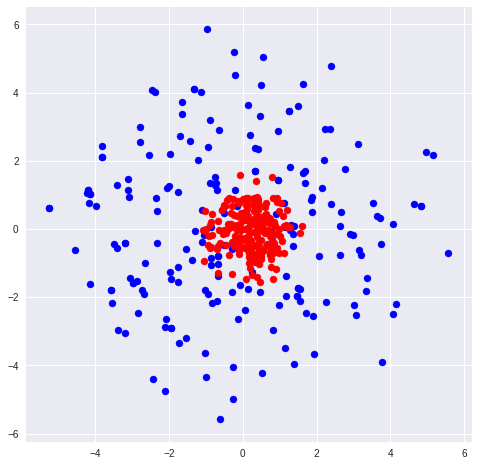

In [0]:
printDataSet2D(XPCA,y)

## MDS
Multidimensional Scaling. Dąży do tego, aby w przestrzeni wielowymiarowej obiekty podobne do siebie znajdowały się bliżej, a różne od siebie dalej. Na wejściu procedury jest zwykle macierz odległości lub podobieństwa pomiędzy obiektami (np. macierz korelacji). 

In [0]:
seed = np.random.RandomState(seed=2)
mds = manifold.MDS(n_components=2, max_iter=10)
XMDS = mds.fit_transform(X)

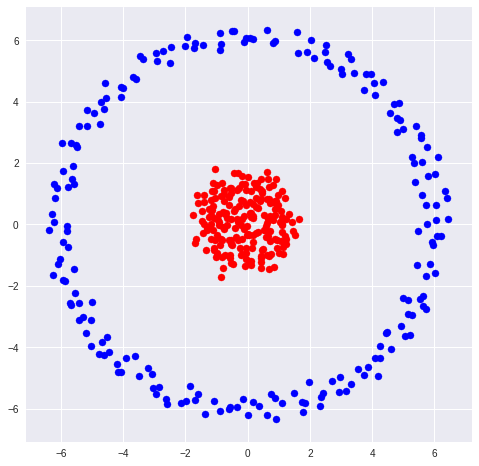

In [0]:
printDataSet2D(XMDS,y)

# Metoda Isomap
Isometric Mapping. Służy do tworzenia takiego mniej wymiarowego odwzorowania, które zachowuje odległości pomiędzy wszystkimi punktami. Można podzielić ją na 3 etapy: wyszukiwanie najbliższego sąsiada, wyszukiwanie najkrótszej drogi, skalowanie (stosowany jest tu MDS).

In [0]:
ISO = manifold.Isomap(n_components=2)
XISO = ISO.fit_transform(X)

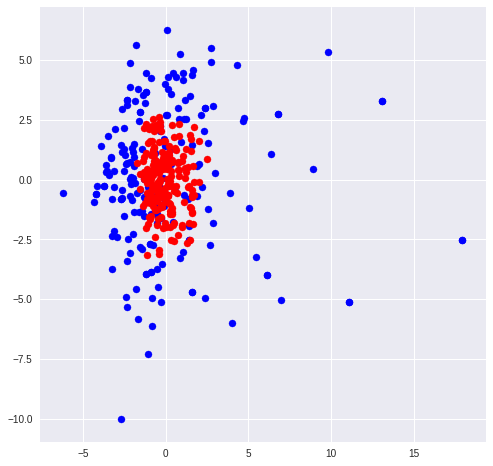

In [0]:
printDataSet2D(XISO,y)

# Metoda LLE (Locally Linear Embedding)
Pozwala uzyskać odwzorowanie o mniejszej liczbie wymiarów z zachowaniem odległości w obrębie lokalnych sąsiedztw. Można myśleć o nim jako o serii lokalnych PCA, które następnie są porównywane w celu znalezienia najlepszego odzworowania. Obejmuje kroki: znalezienie najbliższych sąsiadów dla każdego z punktów, obliczenie macierzy wag rekonstrukcji.

In [0]:
LLE = manifold.LocallyLinearEmbedding(n_neighbors = 6, n_components=2)
XLLE = LLE.fit_transform(X)

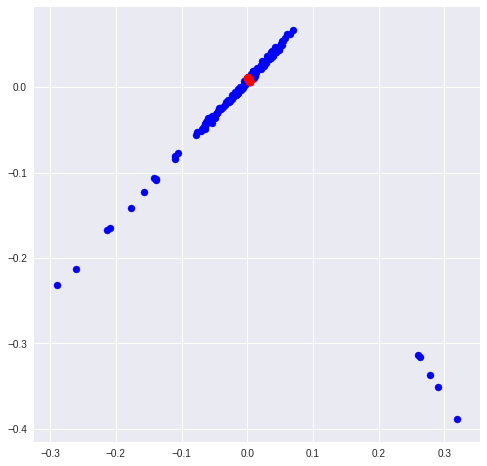

In [0]:
printDataSet2D(XLLE,y)

## Dokładniejszy opis metod
https://scikit-learn.org/stable/modules/manifold.html

# Metryki najbliższego sąsiada

In [0]:
def near_nei(k, samples):    
    nbrs = NearestNeighbors(k+1, algorithm='ball_tree').fit(samples)
    distances, indexes = nbrs.kneighbors(samples)
    res = []
    for index in indexes:
      tmp = samples.shape[0]
      if index[0] < (tmp)/2:
        res.append((len(list(filter(lambda x: x < len(samples)/2, index)))-1)/k)
      else:
        res.append((len(list(filter(lambda x: x >= len(samples)/2, index)))-1)/k)
      
    return np.mean(res)
  
  
def knn(k, n ,samples, method, M):
    nbrs_n_dim = NearestNeighbors(k, algorithm='ball_tree').fit(samples)
    _, indexes_in_n_dim = nbrs_n_dim.kneighbors(samples)
    samples_in_2_dim = method.fit_transform(samples)
    nbrs_2_dim = NearestNeighbors(k, algorithm='ball_tree').fit(samples_in_2_dim)
    _, indexes_in_2_dim = nbrs_2_dim.kneighbors(samples_in_2_dim)
    same_neighbors = 0
    for a,b in zip(indexes_in_n_dim,indexes_in_2_dim):
        same_neighbors += len(set(a).intersection(set(b)))
    return same_neighbors/(k*M) 

401


In [85]:
print("PCA", near_nei(3, pca.fit_transform(X)))
print("MDS", near_nei(3, mds.fit_transform(X)))
print("Isomap", near_nei(3, ISO.fit_transform(X)))
print("LLE", near_nei(3, LLE.fit_transform(X)))

PCA 0.8669991687448045
MDS 0.9950124688279302
Isomap 0.7024106400665004
LLE 0.7788861180382378


In [87]:
print("PCA", knn(3, 3, X, pca, len(X)))
print("MDS", knn(3, 3, X, mds, len(X)))
print("Isomap", knn(3, 3, X, ISO, len(X)))
print("LLE", knn(3, 3, X, LLE, len(X)))

PCA 0.40648379052369077
MDS 0.343308395677473
Isomap 0.4023275145469659
LLE 0.39900249376558605


# Shepard Diagram

In [0]:
def shepard_diagram(k, samples, method):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1)
    colors = ['r', 'b']
    samples_in_2_dim = method.fit_transform(samples)
    n_dims = euclidean_distances(samples, samples)
    two_dims = euclidean_distances(samples_in_2_dim, samples_in_2_dim)
    for dst1, dst2 in zip(n_dims, two_dims):
      ax.scatter(dst2
                   , dst1
                   , c = colors[0]
                   , s = 50)
    plt.show()

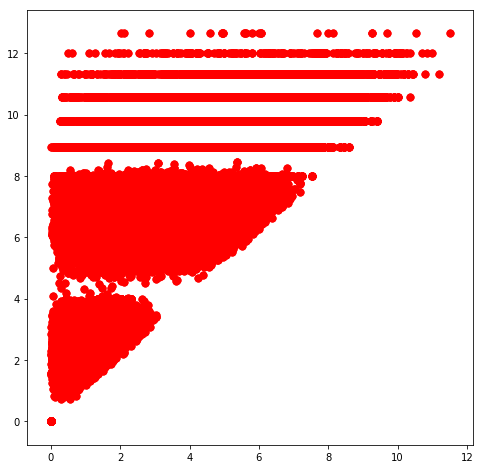

In [99]:
shepard_diagram(10, X, pca) 

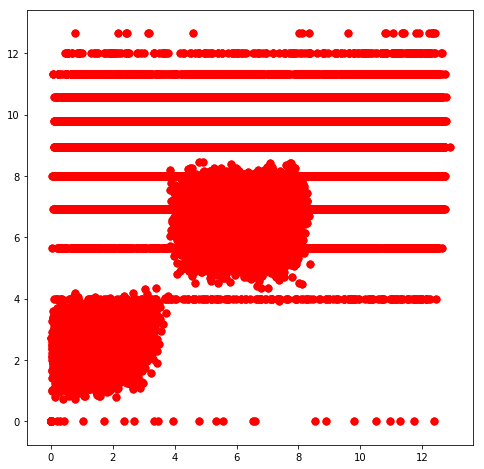

In [100]:
shepard_diagram(10, X, mds) 

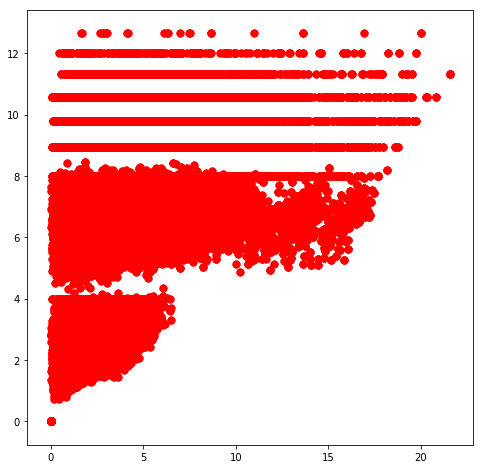

In [101]:
shepard_diagram(10, X, ISO) 

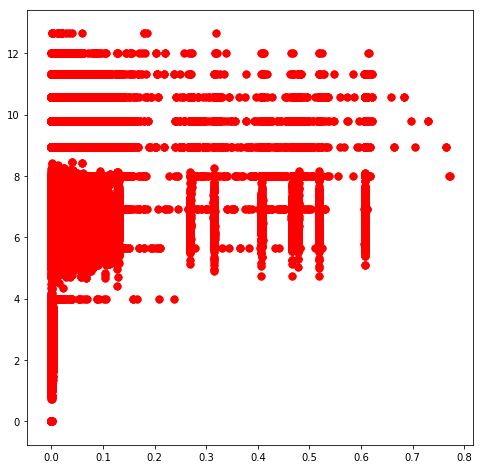

In [102]:
shepard_diagram(10, X, LLE) 

# Zbiór Breast Cancer Wisconsin   

In [0]:
names = ['Clump Thickness', 'Uniformity of Cell Size', 
         'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 
         'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class:']

df = pd.read_csv('breast_cancer.csv', names=names)

print(df.shape)
df.head(10)

(697, 10)


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class:
0,5,4,4,5,7,10,3,2,1,2
1,3,1,1,1,2,2,3,1,1,2
2,6,8,8,1,3,4,3,7,1,2
3,4,1,1,3,2,1,3,1,1,2
4,8,10,10,8,7,10,9,7,1,4
5,1,1,1,1,2,10,3,1,1,2
6,2,1,2,1,2,1,3,1,1,2
7,2,1,1,1,2,1,1,1,5,2
8,4,2,1,1,2,1,2,1,1,2
9,1,1,1,1,1,1,3,1,1,2


In [0]:
x = list(filter(lambda x: '?' not in x, df.loc[:, names].values))

pca = PCA(n_components=2)
mds = manifold.MDS(n_components=2)
lle = manifold.LocallyLinearEmbedding(n_neighbors = 6, n_components=2)
iso = manifold.Isomap(n_components=2)

# Metryki najbliższego sąsiada

In [0]:
# Dodatek - względem danej cechy (jak na laboratorium 1)
def near_nei_lab(k, samples):    
    nbrs = NearestNeighbors(k, algorithm='ball_tree').fit(samples)
    _, indexes = nbrs.kneighbors(samples)
    res = []
    for index, neighbours in enumerate(indexes):
        close = [x for x in neighbours if labels[index] == labels[x]]
        res.append(len(close) / k)        
    return np.mean(res)
  
  
def knn_lab(k, n, samples, method, M, labels):
    nbrs_n_dim = NearestNeighbors(k, algorithm='ball_tree').fit(samples)
    _, indexes_in_n_dim = nbrs_n_dim.kneighbors(samples)
    close_n = [[x for x in neighbours if labels[index] == labels[x]] for index, 
               neighbours in enumerate(indexes_in_n_dim)]
        
    samples_in_2_dim = method.fit_transform(samples)
    nbrs_2_dim = NearestNeighbors(k, algorithm='ball_tree').fit(samples_in_2_dim)
    _, indexes_in_2_dim = nbrs_2_dim.kneighbors(samples_in_2_dim)
    close_2 = [[x for x in neighbours if labels[index] == labels[x]] for index, 
               neighbours in enumerate(indexes_in_2_dim)]
        
    same_neighbors = 0
    for a,b in zip(close_n, close_2):
        same_neighbors += len(set(a).intersection(set(b)))
    return same_neighbors/(k*M)

In [0]:
print("PCA", near_nei(3, pca.fit_transform(x)))
print("MDS", near_nei(3, mds.fit_transform(x)))
print("Isomap", near_nei(3, iso.fit_transform(x)))
print("LLE", near_nei(3, lle.fit_transform(x)))

PCA 0.18880809312091903
MDS 0.2762270857713028
Isomap 0.3677678989663088
LLE 0.0017342858534334395


In [0]:
print("PCA", knn(3, 3, x, pca, len(x)))
print("MDS", knn(3, 3, x, mds, len(x)))
print("Isomap", knn(3, 3, x, iso, len(x)))
print("LLE", knn(3, 3, x, lle, len(x)))

PCA 0.39158100832109644
MDS 0.39255996084189915
Isomap 0.3969652471855115
LLE 0.3308859520313265


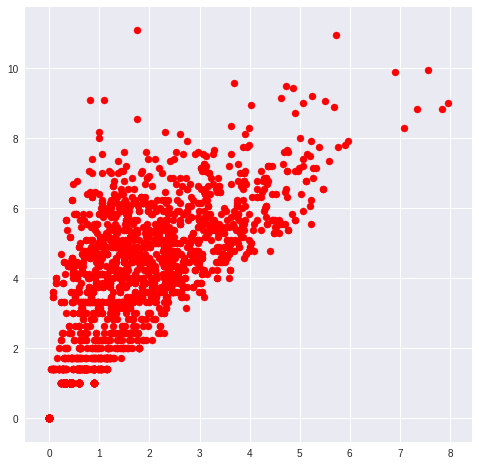

In [0]:
shepard_diagram(6, x, pca) 

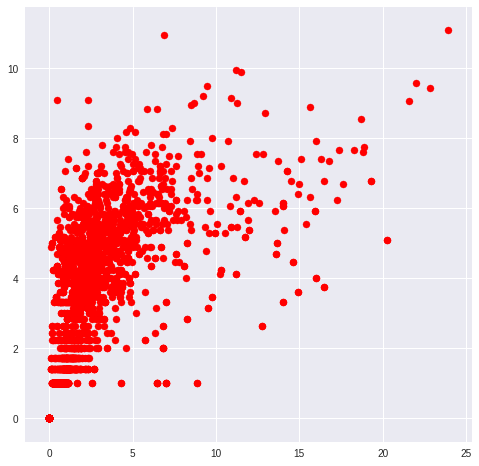

In [0]:
shepard_diagram(6, x, mds) 

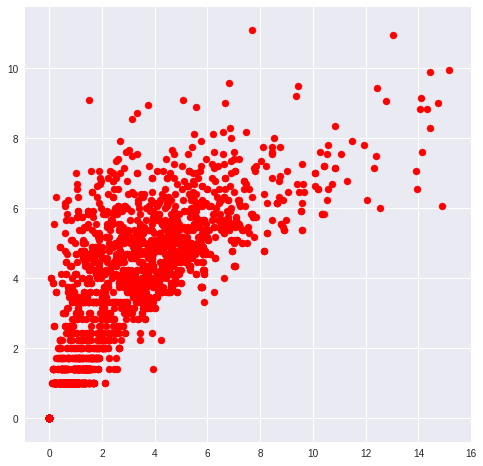

In [0]:
shepard_diagram(6, x, iso) 

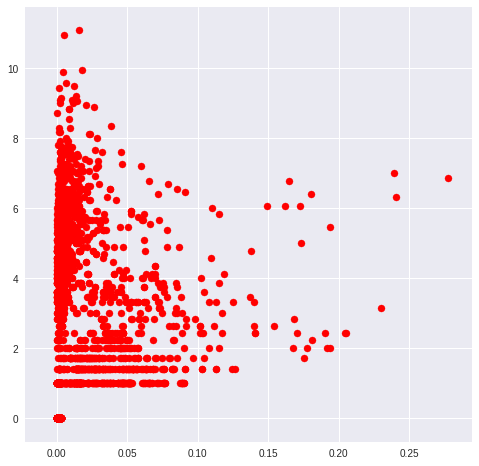

In [0]:
shepard_diagram(6, x, lle) 

# Zadania do zrobienia na zajęciach

### 1. Użyć danych z pliku globes.csv, który zawiera dwie kule o środkach w punktach (2,2) i (-2,2) oraz o promieniu 1.
Dla tego zbioru dogenerować 10-100 dodatkowych wymiarów z losowymi wartościami z przedziału (-1,1). Na koniec sprawdzić, która metoda najlepiej wizualizuje i odseparowywuje dwa klastry.

In [0]:
# Dla korzystających z Colaba
from google.colab import files
globes = files.upload()

In [0]:
globes = np.genfromtxt('globes.csv', delimiter=',')

In [0]:
def printGlobe(points):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    colors = ['r', 'b']
    for i, a in enumerate(points):
            c = 'r' if i < len(points)/2 else 'b'
            ax.scatter(a[0]
                       , a[1]
                       , c = c
                       , s = 50)
    plt.show()

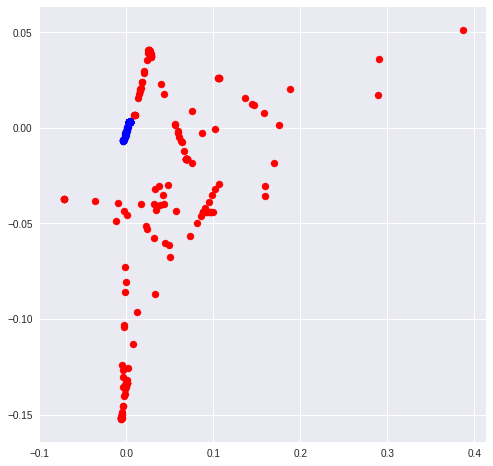

In [0]:
LLE = manifold.LocallyLinearEmbedding(n_neighbors = 3, n_components=2)
globeLLE = LLE.fit_transform(globes)
printGlobe(globeLLE)

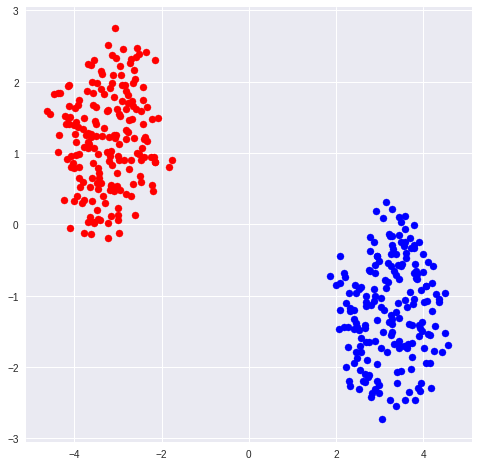

In [0]:
globeMds = mds.fit_transform(globes)
printGlobe(globeMds)

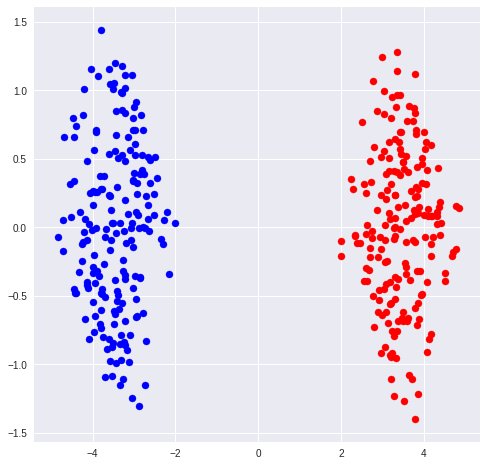

In [0]:
globePca = pca.fit_transform(globes)
printGlobe(globePca)

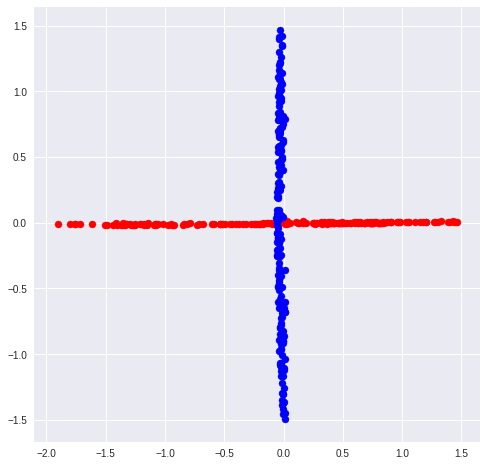

In [0]:
globeIso = iso.fit_transform(globes)
printGlobe(globeIso)

### Dogenerowujemy wymiary

In [0]:
additional_dims = 100

globes_extended = np.array([list(globe) + 
                            [random.uniform(-1, 1) for i in range(additional_dims)] 
                            for globe in globes])

### 2. Dla podzbioru Mnista sprawdzić metryki dla każdej metody oraz wygenerować diagramy Sheparda. 
Dodatkowo sporządzić tabelkę z wynikami dla metryki near_nei i knn dla każdej z metod (2x4).

Zbiór 1: cifar.csv

Zbiór 2: zalando.csv

In [0]:
mnist = np.genfromtxt('mnist.csv', delimiter=',')

pca = PCA(n_components=2)
mds = manifold.MDS(n_components=2)
lle = manifold.LocallyLinearEmbedding(n_neighbors = 6, n_components=2)
iso = manifold.Isomap(n_components=2)